In [ ]:
import sys
sys.path.insert(0, '../../Models/ANN')

In [1]:
# Import libraries
import torch
import pandas as pd
import numpy as np
import hyperopt
from hyperopt import fmin, tpe, Trials, hp
import hyperopt.pyll.stochastic
from hyperopt import pyll

# Import Modules
from Kfold_test_model import Kfold_test_model
from test_model import test_model
from test_hidden import test_hidden

# Set device to GPU if possible
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)


# Get Data - missing values set to 0 - i.e. the mean (due to standardisation)
x = pd.read_csv('../../Data/Missing_0_Mask/X_train_0.csv').to_numpy()
y = pd.read_csv('../../Data/Y_train.csv').to_numpy()
xt = pd.read_csv('../../Data/Missing_0_Mask/X_test_0.csv').to_numpy()
yt = pd.read_csv('../../Data/Y_test.csv').to_numpy()
Xht = pd.read_csv("../../Data/Missing_0_Mask/X_hidden_0.csv").to_numpy()
yht = pd.read_csv("../../Data/Y_hidden.csv").to_numpy()



# Set class weights - Currently all 1s as data is balanced through trainloader
cw = torch.FloatTensor(np.ones(12)).to(device)

# Hyperopt function
def search_reg(space, max_eval, output_path):
    T = Trials()
    best = fmin(optimiser, space, algo=tpe.suggest, max_evals=max_eval, trials=T, pass_expr_memo_ctrl=True)
    
    logs = []
    results = []
    
    T.trials
    for i in T.trials:
        logs.append(i['misc']['vals'])
        results.append(i['result']['loss'])
    
    trial_data = pd.DataFrame(logs)
    trial_data['F1'] = results
    trial_data.to_csv(output_path)
    
    return hyperopt.space_eval(space, best)

# Simple Logistic Regression

## Search

In [2]:
space = {'optim':hp.choice('optim',[
             {
                 'optim': 'adamw',
                 'weight_decay':hp.choice('adamw_weigh_decay',[1e-1,1e-2,1e-3,1e-4]),
                 'LR':hp.choice('adamw_LR', [1e-1,1e-2,1e-3,1e-4,1e-5]),
                 'batch_size':hp.choice('adamw_batch_size', [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12]),
                 'momentum': hp.choice('adamw_momentum', [None]),
                 
             },
             
             {
                 'optim':'sgdm',
                 'weight_decay':hp.choice('sgdm_weigh_decay',[1e-1,1e-2,1e-3,1e-4]),
                 'LR':hp.choice('sgdm_LR', [1e-1,1e-2,1e-3,1e-4,1e-5]),
                 'batch_size':hp.choice('sgdm_batch_size', [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12]),
                 'momentum': hp.uniform('sgdm_momentum', 0, 1 ),
                 
             },
             {
                 'optim':'RMSprop',
                 'weight_decay':hp.choice('RMSprop_weigh_decay',[1e-1,1e-2,1e-3,1e-4]),
                 'LR':hp.choice('RMSprop_LR', [1e-1,1e-2,1e-3,1e-4,1e-5]),
                 'batch_size':hp.choice('RMSprop_batch_size', [2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12]),
                 'momentum': hp.uniform('RMSprop_momentum', 0, 1)
             },
             
         ])
        }

In [3]:
def optimiser(expr, memo, ctrl):
    try:
        config = pyll.rec_eval(expr, memo=memo)
        print(config)
        if len(ctrl.trials.losses()) > 1:
            best_score = -min(value for value in ctrl.trials.losses() if value is not None)
        else:
            best_score = -5

        return -Kfold_test_model(device, X, y,cw, [26,12], 0, config['optim']['batch_size'], config['optim']['LR'], 3, config['optim']['weight_decay'],None, config['optim']['optim'], True, config['optim']['momentum'], best_score)
    
    except:
        return 99

In [ ]:
search_reg(space, 100, 'LR.csv')
# Cell accidently cleared but file still available. Top model used below.

--------------------------------
FOLD 0
--------------------------------
<bound method Module.parameters of Net(
  (hidden): ModuleList(
    (0): Linear(in_features=26, out_features=12, bias=True)
  )
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0, inplace=False)
)>
Training Runtime: 22.232487678527832
********************************
Training Data Class F1 Scores: 
[0.51178613 0.33891572 0.6170515  0.20549214 0.01093118 0.47004765
 0.47453075 0.87170545 0.31914894 0.12491993 0.1386938  0.03855307]
********************************
Validation Data Class F1 Scores: 
[0.5113685  0.33478058 0.6177122  0.20961323 0.01195145 0.46761494
 0.47622531 0.87731544 0.31689572 0.12588652 0.14032801 0.03903346]
********************************
Fold 0 Validation Score: -1.511587848083963
--------------------------------
FOLD 1
--------------------------------
<bound method Module.parameters of Net(
  (hidden): ModuleList(
    (0): Linear(in_features=26, out_features=12, bias=True)
  )
  (softmax

-1.545235089832637

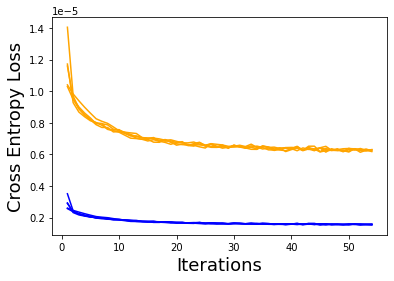

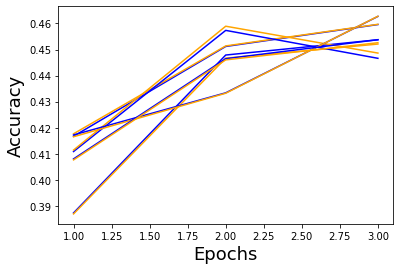

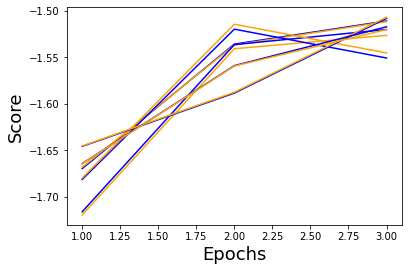

In [2]:
Kfold_test_model(device, X, y,cw, [26,12], 0, 512, 1e-3, 3, 0.01,None, 'adamw', True, None)

## Top Logistic Regression Model

<bound method Module.parameters of Net(
  (hidden): ModuleList(
    (0): Linear(in_features=26, out_features=12, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)>
Training Runtime: 1758.310019493103
********************************
Training Data Class F1 Scores: 
[0.50427423 0.25320687 0.79341939 0.04832222 0.         0.27319215
 0.38862151 0.         0.         0.00248528 0.46880508 0.        ]
Validation Data Class F1 Scores: 
[0.19690633 0.23256179 0.73176978 0.         0.         0.08372429
 0.         0.         0.         0.43810445]
********************************
********************************
Training Accuracy: 0.6267245673043653
Test Accuracy: 0.5258140452970334
********************************
Training Score: [-1.04532315]
Test Score: [-1.24539609]
********************************


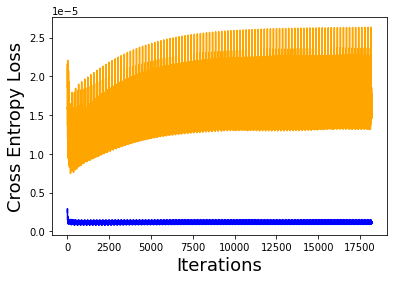

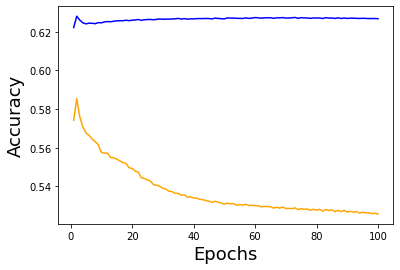

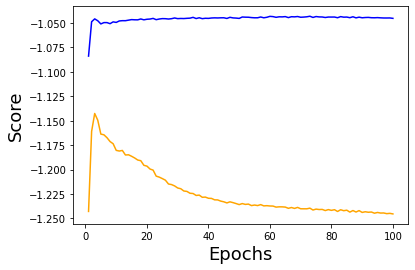

In [3]:
LR_1 = test_model(device, X, y, Xt, yt, cw, [26,12], 0, 64, 0.001, 100, 0.001, None, 'adamw', False, momentum=None)

The results suggest the model is overfitting. This may be due to the batch size being too small. We increase this to 256.

In [ ]:
LR_2 = test_model(device, X, y, Xt, yt, cw, [26,12], 0, 256, 0.001, 100, 0.001, None, 'adamw', False, momentum=None)

The change to batch size has smoothed out the validation loss curve. The Accuracy and score curves suggest there is still overfitting. Furthermore the ossiclations in loss curve suggest the learning rate may be too high. We decrease the learning rate by factor 10 and increase the weight decay by factor 100.

<bound method Module.parameters of Net(
  (hidden): ModuleList(
    (0): Linear(in_features=26, out_features=12, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)>
Training Runtime: 883.2886354923248
********************************
Training Data Class F1 Scores: 
[0.55756451 0.06601374 0.83818008 0.00913079 0.         0.51609129
 0.         0.53888601 0.02661934 0.         0.03835336 0.01904762]
Validation Data Class F1 Scores: 
[0.60931216 0.06967305 0.83363308 0.         0.         0.47136038
 0.         0.         0.         0.00578035]
********************************
********************************
Training Accuracy: 0.7068049766298651
Test Accuracy: 0.7002763440702996
********************************
Training Score: [-0.82215257]
Test Score: [-0.8380801]
********************************


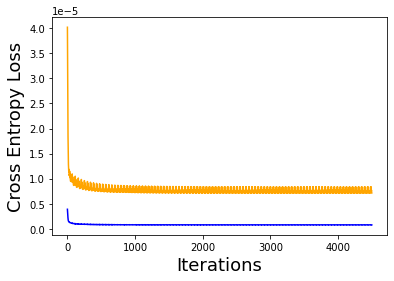

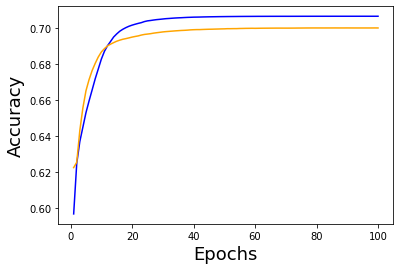

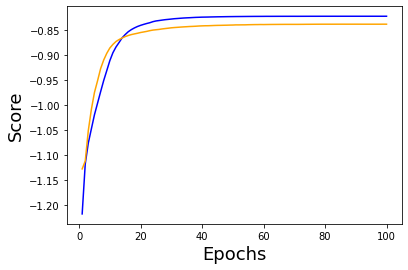

In [8]:
LR_3 = test_model(device, X, y, Xt, yt, cw, [26,12], 0, 256, 0.0001, 100, 0.1, None, 'adamw', False, momentum=None)

This change seems to have drasticaly improved the model. Validation and training score and accuracy move quite closely suggesting good generalisation. The validation loss seems more stable and steadily decrasing. We try increasing the weight decay a little more to see if it improves the model further. We increase it to 0.3.

<bound method Module.parameters of Net(
  (hidden): ModuleList(
    (0): Linear(in_features=26, out_features=12, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)>
Training Runtime: 878.9696788787842
********************************
Training Data Class F1 Scores: 
[0.41298284 0.0540305  0.81877877 0.         0.         0.21803849
 0.         0.03831053 0.         0.         0.         0.        ]
Validation Data Class F1 Scores: 
[0.54559003 0.03336676 0.8154839  0.         0.         0.25027721
 0.         0.         0.         0.        ]
********************************
********************************
Training Accuracy: 0.6681560446676708
Test Accuracy: 0.6769333118886436
********************************
Training Score: [-0.96328078]
Test Score: [-0.92672678]
********************************


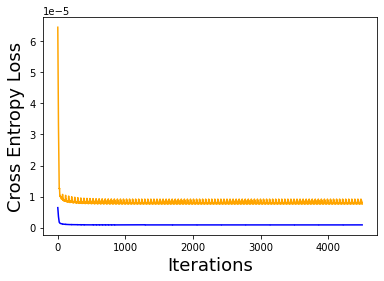

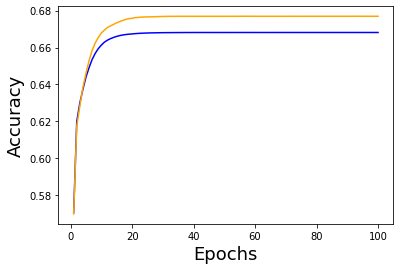

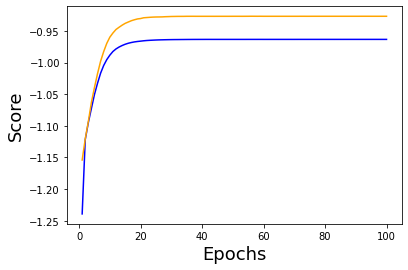

In [9]:
LR_4 = test_model(device, X, y, Xt, yt, cw, [26,12], 0, 256, 0.0001, 100, 0.3, None, 'adamw', False, momentum=None)

Increasing the weight decay here has reduced performance on both validation and training datasets. Thus we select LR_3 as our best logistic regression model.

Top Model: LR_3
********************************
Training Accuracy: 0.7068049766298651
********************************
Test Accuracy: 0.7002763440702996
********************************
Training Score: -0.82215257
********************************
Test Score: -0.8380801
********************************